# Contrastive Language-Image Pre-training

This demo is based on the excellent tutorial [here](https://towardsdatascience.com/simple-implementation-of-openai-clip-model-a-tutorial-ace6ff01d9f2).

In this demo, we implement Contrastive Language-Image Pre-training (CLIP). At a high level, CLIP embeds images and text pairs to a small latent space. The goal is to make the embeddings of image and text pairs similar to each other. In this way, we want the embeddings to capture meaning which *transcends* the difference between language and images.

We achieve this goal by encouraging the embedded text and image pair to have high inner product while keeping the inner product of texts and images that are not pairs low.

CLIP has been an important component of the break through generative models including Stable Diffusion.

## Dependencies

We'll need a few dependencies to get started.

In [ ]:
!pip install timm
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 5.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 42.6 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

<ipython-input-2-1950ad4227b5>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


I've been unable to load Flickr8 through pytorch. Instead, we'll use kaggle (we'll need to link a free account to the download).

In [3]:
!pip install kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = 'sujaybanerjee'
os.environ['KAGGLE_KEY'] = 'ea1671238fe0ee6d3573c54242bf1f4a'

### For Flickr 8k
!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

## Hyperparameters

We will use the following hyperparameters.

In [4]:
class config:
    image_path = "/content/Images"
    captions_path = "/content"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    text_tokenizer = "distilbert-base-uncased"

## Dataset

Whenever we work with text and images, we'll need to do a bit of tedious preprocessing. Here, we'll have to tokenize the sentence descriptions of images before passing them through an embedding and apply a transform to the images before loading them.

In [5]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames # one description per image
        self.captions = list(captions) # one description per image
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=200
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{config.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)

## Embeddings

We'll need a way of encoding the images and text. For the images, we'll use a ResNet to get images down to a latent space of 2048. For the text, we'll use a Bert model to get images down to a latent space of 768.

Of course, to compare the embedded texts and images, they'll have to live in the same dimension. We can fix this by adding a projection head on top of the embeddings.

In [6]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name='resnet50', pretrained=True, trainable=True
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [7]:
class TextEncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", pretrained=True, trainable=True):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [8]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=256,
        dropout=0
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP Architecture

Now we're ready to implement the CLIP architecture. As we discussed, we'll first have to embed the texts and images and apply the projection head to get embedded vectors in the same dimension.

Once we have the embedded vectors in hand, we'll compute the loss by taking the outer product of the embedded images with the embedded texts. This gives a Gram matrix where entry $(i,j)$ is the inner product between the $i$th text embedding and $j$th image embedding. If we didn't have text or image duplicates, we'd want this matrix to be as close to the identity as possible: entry $(i,i)$ is the inner product between the $i$th image and text pair which we want to be large while entry $(i,j)$ (for $i\neq j$) should be small.

We can encourage this by making our loss the cross entropy loss between the identity matrix and our gram matrix.
The picture gets a little bit more complicated when we have duplicates (each image has five different captions). We can deal with this by replacing the identity matrix with a matrix encoding whether different texts (images) are the same.

In [9]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=1,
        image_embedding=2048,
        text_embedding=768,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        batch_size = len(image_embeddings) 
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        #computed because some images are repeated in the examples
        #and we want to push the inner products to 1 if theyre the same
        #
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

Here's an example of what we're doing to get the target matrices.

In [10]:
# A simple Example

batch_size = 4
dim = 128
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(out)
print(F.softmax(out, dim=-1))

tensor([[159.7713,   3.9808, -15.7330,  14.0463],
        [  3.9808, 118.0532, -15.5809,   9.5372],
        [-15.7330, -15.5809, 114.7063,  -3.3190],
        [ 14.0463,   9.5372,  -3.3190, 114.9537]])
tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [1.5414e-44, 0.0000e+00, 0.0000e+00, 1.0000e+00]])


## Training

Here are some helper functions to load the training and validation dataloaders.

In [15]:
def make_train_valid_dfs():
    dataframe = pd.read_csv("captions.txt")
    max_id = dataframe["id"].max().index
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ]
    )
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=2,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [16]:
dataframe, _ = make_train_valid_dfs()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
transforms = A.Compose(
    [
        A.Resize(224, 224, always_apply=True),
        A.Normalize(max_pixel_value=255.0, always_apply=True),
    ]
)
dataset = CLIPDataset(
    dataframe["image"].values,
    dataframe["caption"].values,
    tokenizer=tokenizer,
    transforms=transforms,
  )

KeyError: ignored

Here are the standard evaluation and training functions we are by now very familiar with.

In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(config.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(config.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter



Now let's load the dataset into a dataframe.

In [ ]:
df = pd.read_csv("captions.txt")
df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
df.to_csv("captions.csv", index=False)
df = pd.read_csv("captions.csv")
df.head()

,image,caption,id
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,0
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,0


Finally, we'll initialize dataloaders, model, parameter, optimizer, and scheduler. With all this in hand, we can train. Each epoch takes about 9 minutes on the GPU.

In [ ]:
train_df, valid_df = make_train_valid_dfs()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


model = CLIPModel().to(config.device)
params = [
    {"params": model.image_encoder.parameters(), "lr": 1e-4},
    {"params": model.text_encoder.parameters(), "lr": 1e-5},
    {"params": itertools.chain(
        model.image_projection.parameters(), model.text_projection.parameters()
    ), "lr": 1e-3, "weight_decay": 1e-3}
]
optimizer = torch.optim.AdamW(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=1, factor=.8
)
step = "epoch"

best_loss = float('inf')
for epoch in range(1):
    print(f"Epoch: {epoch + 1}")
    model.train()
    train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
    model.eval()
    with torch.no_grad():
        valid_loss = valid_epoch(model, valid_loader)
    
    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        torch.save(model.state_dict(), "best.pt")
        print("Saved Best Model!")
    
    lr_scheduler.step(valid_loss.avg)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!


## Evaluation

Now let's try to search---either images or text---using our trained embeddings!

We'll start by embedding all the text in the validation set and all the images in the validation set. Note: the model has *not* been trained on the data we will be searching over.

In [ ]:
def get_image_embeddings(model, valid_loader): 
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(config.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)

def get_text_embeddings(model, valid_loader, tokenizer):
  
  model.eval()
  
  valid_text_embeddings = []
  with torch.no_grad():
    for batch in tqdm(valid_loader):
      encoded = tokenizer(batch['caption'])
      text_features = model.text_encoder(
                  input_ids=batch["input_ids"].to(config.device), attention_mask=batch["attention_mask"].to(config.device)
      )
      text_embeddings = model.text_projection(text_features)
      valid_text_embeddings.append(text_embeddings)
  
  return torch.cat(valid_text_embeddings)

In [ ]:
image_embeddings = get_image_embeddings(model, valid_loader)
text_embeddings = get_text_embeddings(model, valid_loader, tokenizer)

  0%|          | 0/253 [00:00<?, ?it/s]

Now we willl write code to search over the embedded text with an image OR search over the embedded images with text.

In [ ]:
def find_matching_text(model, text_embeddings, query, captions, n=9):
  with torch.no_grad():
    query = torch.unsqueeze(query, 0)
    image_features = model.image_encoder(query.to(config.device))
    image_embeddings = model.image_projection(image_features)

  image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
  text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
  dot_similarity = image_embeddings_n @ text_embeddings_n.T
  values, indices = torch.topk(dot_similarity, n * 5)

  matches = [captions[idx] for idx in indices.cpu()[::5]][0]

  for i in range(n):
    print(matches[i])
  

def find_matching_images(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(config.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(config.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    _, axes = plt.subplots(int(np.sqrt(n)), int(np.sqrt(n)), figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{config.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

Let's start by searching over the embedded images. If we searching for 'person climbing rock', the returned images all include climbers!

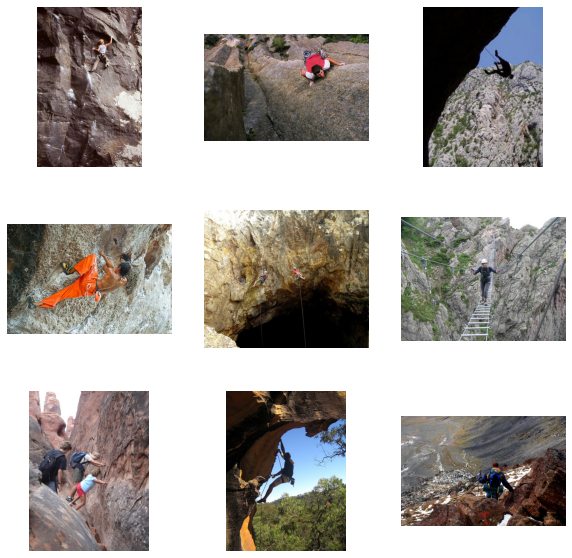

In [ ]:
find_matching_images(model, image_embeddings,
                     query='person climbing rock',
                     image_filenames=valid_df['image'].values)

Now let's try it in the reverse. We'll load an image from the training data and search over the embedded text descriptions in the validation set.

A shirtless man is doing a skateboard trick .
A man in a white helmet crouches while he skateboards .
A shirtless man rides a skateboard .
A teenage male grinds on his skateboard .
A shirtless man skateboarding with his arms in the air .
A boy skateboarding .
A boy skateboarding .
A person wearing a helmet and red and silver jumpsuit is kneeling on a skateboard .
He is in the air on his skateboard .


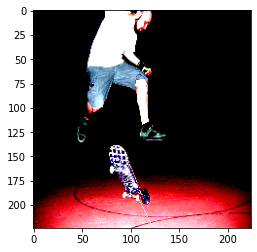

In [ ]:
batch = next(iter(train_loader))
image = batch['image'][3]
plt.imshow(image.permute(1, 2, 0))
find_matching_text(model, text_embeddings,
                   query=image,
                   captions=valid_df['caption'].values)